In [1]:
import pandas as pd
import pydicom 
import os

In [4]:
df=pd.read_csv("stage_1_train.csv")

In [11]:
df.head()

,ID,Label,Image_Number,Type,Image_Name
0,ID_63eb1e259_epidural,0,63eb1e259,epidural,ID_63eb1e259.dcm
1,ID_63eb1e259_intraparenchymal,0,63eb1e259,intraparenchymal,ID_63eb1e259.dcm
2,ID_63eb1e259_intraventricular,0,63eb1e259,intraventricular,ID_63eb1e259.dcm
3,ID_63eb1e259_subarachnoid,0,63eb1e259,subarachnoid,ID_63eb1e259.dcm
4,ID_63eb1e259_subdural,0,63eb1e259,subdural,ID_63eb1e259.dcm


In [6]:
df[['ID_1','Image_type']] = df.ID.str.split("_",n=1,expand=True) 
df[['Image_Number','Type']]=df.Image_type.str.split("_",expand=True)
df['Image_Name']='ID'+'_'+df['Image_Number']+'.dcm'
df.head();df.pop('ID_1');df.pop('Image_type')
df.head()

,ID,Label,Image_Number,Type,Image_Name
0,ID_63eb1e259_epidural,0,63eb1e259,epidural,ID_63eb1e259.dcm
1,ID_63eb1e259_intraparenchymal,0,63eb1e259,intraparenchymal,ID_63eb1e259.dcm
2,ID_63eb1e259_intraventricular,0,63eb1e259,intraventricular,ID_63eb1e259.dcm
3,ID_63eb1e259_subarachnoid,0,63eb1e259,subarachnoid,ID_63eb1e259.dcm
4,ID_63eb1e259_subdural,0,63eb1e259,subdural,ID_63eb1e259.dcm


In [7]:
import os

directory='stage_1_train_images'



EXPLORING RAW DATA 


Filename.........: stage_1_train_images/ID_ba33eab65.dcm
[[126 128 128 ... 139 138 135]
 [124 125 127 ... 139 137 135]
 [125 123 122 ... 136 136 136]
 ...
 [168 172 175 ... 196 195 189]
 [171 174 173 ... 193 197 196]
 [171 171 168 ... 188 193 196]]

Image size.......: 512 x 512, 524288 bytes
Pixel spacing....: ['0.494750976563', '0.494750976563']
Slice location...: (missing)


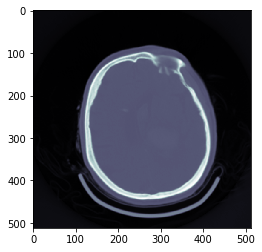

In [12]:

import matplotlib.pyplot as plt
import pydicom

for filename in os.listdir(directory)[:1]:
    if filename.endswith(".dcm"):
        filename=os.path.join(directory, filename)

        dataset = pydicom.dcmread(filename)

        print()
        print("Filename.........:", filename)
        print(dataset.pixel_array)
        print()

        if 'PixelData' in dataset:
            rows = int(dataset.Rows)
            cols = int(dataset.Columns)
            print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
                rows=rows, cols=cols, size=len(dataset.PixelData)))
            if 'PixelSpacing' in dataset:
                print("Pixel spacing....:", dataset.PixelSpacing)

        print("Slice location...:", dataset.get('SliceLocation', "(missing)"))

        plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
        plt.show()


In [9]:
print(dataset)

(0008, 0018) SOP Instance UID                    UI: ID_ba33eab65
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_557ed4c1'
(0020, 000d) Study Instance UID                  UI: ID_511139bac1
(0020, 000e) Series Instance UID                 UI: ID_382882758b
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-126.408875', '-126.408875', '-82.489609']
(0020, 0037) Image Orientation (Patient)         DS: ['1.000000', '0.000000', '0.000000', '0.000000', '1.000000', '0.000000']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.494750976563', '0.494750976563']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) 

INTERPRETING THE METADATA DATASET

NOW VISUALIZING LIKE A RADIOLOGIST FOR BETTER INFERENCE

In [48]:
from glob import glob

In [49]:
train = sorted(glob("stage_1_train_images/*.dcm"))
test = sorted(glob("stage_1_test_images/*.dcm"))
print("train files: ", len(train))
print("test files: ", len(test))

pd.reset_option('max_colwidth')

train files:  674258
test files:  78545


In [50]:
def window_image(img, window_center,window_width, intercept, slope):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    return img 
    

In [51]:
def get_first_of_dicom_field_as_int(x):
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)


def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]
    

In [52]:
TRAIN_IMG_PATH = "stage_1_train_images"

def view_images(images, title = '', aug = None):
    width = 5
    height = 2
    
    fig, axs = plt.subplots(height, width, figsize=(15,5))
    
    for im in range(0, height * width):
        data = pydicom.read_file(os.path.join(TRAIN_IMG_PATH,images[im]))
        image = data.pixel_array
        window_center , window_width, intercept, slope = get_windowing(data)
        image_windowed = window_image(image, window_center, window_width, intercept, slope)


        i = im // width
        j = im % width
        axs[i,j].imshow(image_windowed, cmap=plt.cm.bone) 
        axs[i,j].axis('off')
        
    plt.suptitle(title)
    plt.show()

In [53]:
print(df['Type'].unique())

['epidural' 'intraparenchymal' 'intraventricular' 'subarachnoid'
 'subdural' 'any']


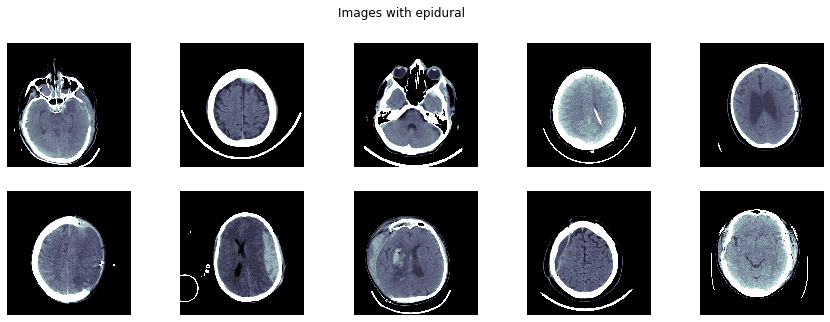

In [54]:
view_images(df[(df['Type'] == 'epidural') & (df['Label'] == 1)][:100].Image_Name.values, title = 'Images with epidural')

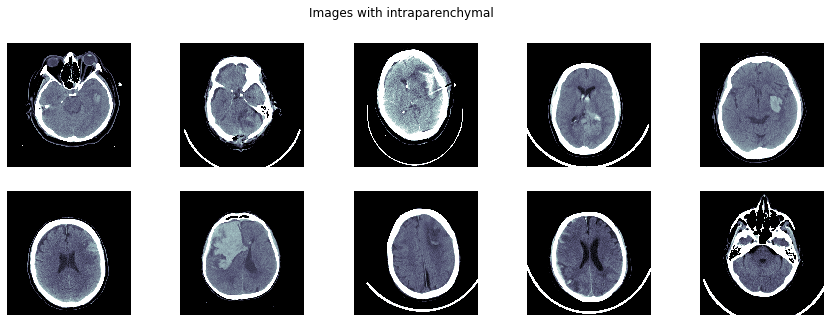

In [55]:
view_images(df[(df['Type'] == 'intraparenchymal') & (df['Label'] == 1)][:10].Image_Name.values, title = 'Images with intraparenchymal')

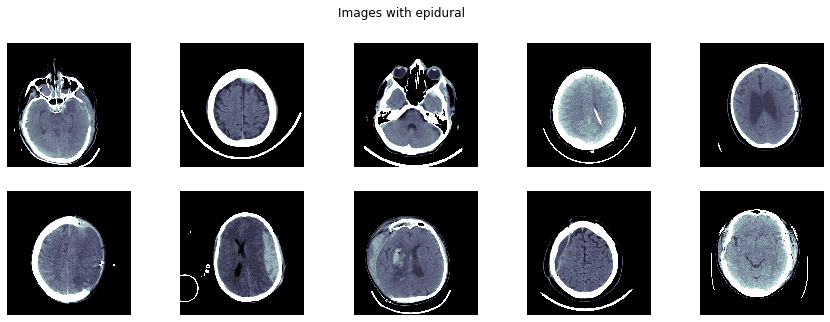

In [56]:
view_images(df[(df['Type'] == 'epidural') & (df['Label'] == 1)][:10].Image_Name.values, title = 'Images with epidural')

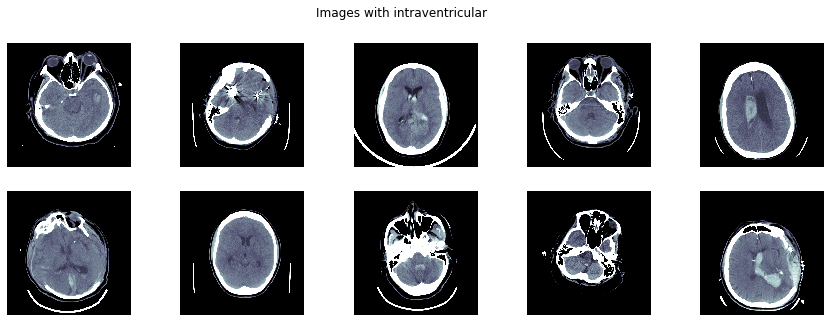

In [57]:
view_images(df[(df['Type'] == 'intraventricular') & (df['Label'] == 1)][:10].Image_Name.values, title = 'Images with intraventricular')

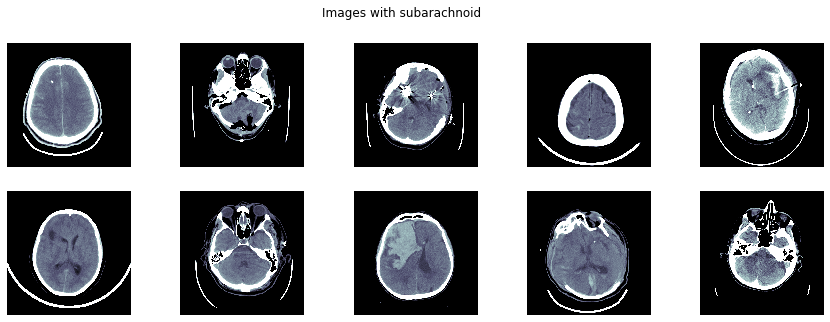

In [58]:
view_images(df[(df['Type'] == 'subarachnoid') & (df['Label'] == 1)][:10].Image_Name.values, title = 'Images with subarachnoid')

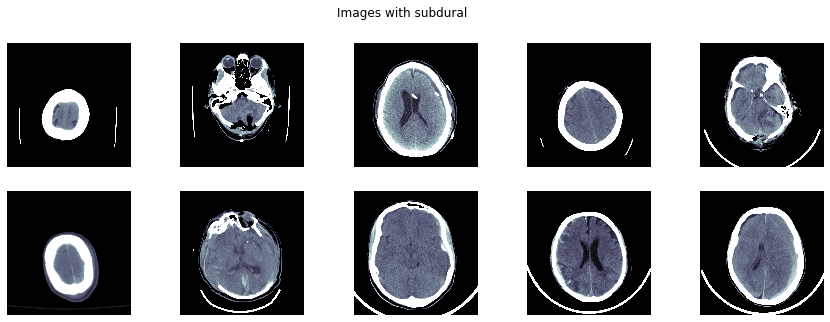

In [59]:
view_images(df[(df['Type'] == 'subdural') & (df['Label'] == 1)][:10].Image_Name.values, title = 'Images with subdural')

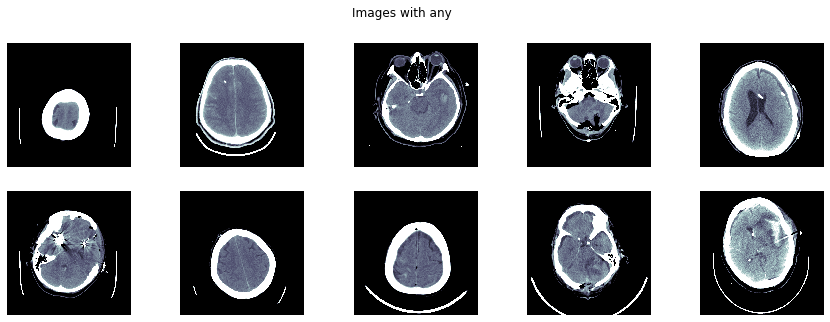

In [60]:
view_images(df[(df['Type'] == 'any') & (df['Label'] == 1)][:10].Image_Name.values, title = 'Images with any')

In [61]:
df.head()

,ID,Label,Image_Number,Type,Image_Name
0,ID_63eb1e259_epidural,0,63eb1e259,epidural,ID_63eb1e259.dcm
1,ID_63eb1e259_intraparenchymal,0,63eb1e259,intraparenchymal,ID_63eb1e259.dcm
2,ID_63eb1e259_intraventricular,0,63eb1e259,intraventricular,ID_63eb1e259.dcm
3,ID_63eb1e259_subarachnoid,0,63eb1e259,subarachnoid,ID_63eb1e259.dcm
4,ID_63eb1e259_subdural,0,63eb1e259,subdural,ID_63eb1e259.dcm


In [62]:
import seaborn as sns

In [63]:
type(pd.value_counts(df.Label))

pandas.core.series.Series

In [64]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 10,5

0    3814760
1     230812
Name: Label, dtype: int64

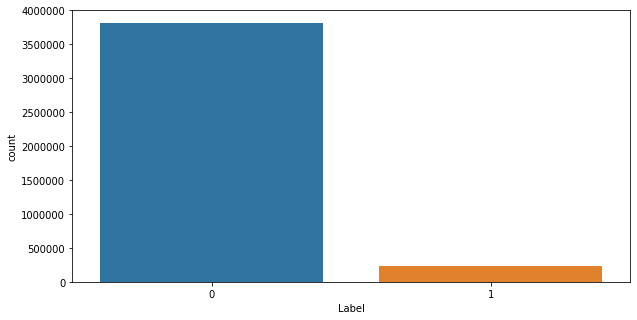

In [65]:
sns.countplot(df.Label)
pd.value_counts(df.Label)

In [66]:
import numpy as np

In [67]:
s=df.groupby('Type').sum()
s.columns=['Value']
s.head()


,Value
Type,
any,97103
epidural,2761
intraparenchymal,32564
intraventricular,23766
subarachnoid,32122


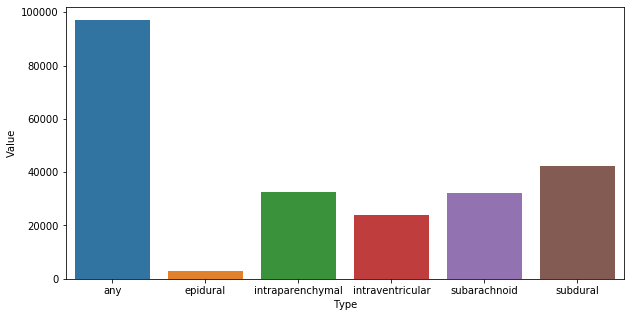

In [68]:
sns.barplot(x=s.index,y=s.Value)

In [69]:
df.head()

,ID,Label,Image_Number,Type,Image_Name
0,ID_63eb1e259_epidural,0,63eb1e259,epidural,ID_63eb1e259.dcm
1,ID_63eb1e259_intraparenchymal,0,63eb1e259,intraparenchymal,ID_63eb1e259.dcm
2,ID_63eb1e259_intraventricular,0,63eb1e259,intraventricular,ID_63eb1e259.dcm
3,ID_63eb1e259_subarachnoid,0,63eb1e259,subarachnoid,ID_63eb1e259.dcm
4,ID_63eb1e259_subdural,0,63eb1e259,subdural,ID_63eb1e259.dcm
